## Семинар 6: "Архитектуры и transfer learning"

ФИО:  Дегтярев Роман Олегович

In [34]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models
import pandas as pd
import os
from skimage import io, transform
from torchvision import models,transforms,datasets
from torchvision.models import alexnet
import time
from tqdm import tqdm


%matplotlib inline
dtype = torch.FloatTensor

На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [35]:
#зададим папки
train_landmarks_path = 'dataset/train/face_landmarks.csv'
train_path = 'dataset/train'
test_landmarks_path = 'dataset/test/face_landmarks.csv'
test_path = 'dataset/test'

In [36]:
#зададим модель
modelAlexnet = alexnet(pretrained=True)

In [37]:
modelAlexnet

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [39]:
#считаем данные
#для этого зададим класс, отнаследованный от dataset. 
# у этого класса будет методы: инициализация и вернуть картинку
class faces(Dataset):
    def __init__(self, csv_file, root_dir, transform= None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [40]:
train = faces(csv_file=train_landmarks_path,
                             root_dir= train_path, 
                             transform=transforms.Compose([ToTensor()])
             )

In [41]:
dataloader = DataLoader(train, batch_size=40,
                        shuffle=True)

In [ ]:
class transferLearning(nn.Module):
    def freeze(self):
        for layer in self.featureLayers:
            for parameter in layer.parameters():
                parameter.requires_grad = False

    def __init__(self):
        super(transferLearning, self).__init__()
        self.convert = torch.nn.UpsamplingNearest2d(size = (224,224))
        self.featureLayers = alexnet(pretrained=True).features
        self.freeze()
        self.linear_layers = torch.nn.Sequential(
              #если посмотреть внимательно model_vgg, то выход со свёрточных слоёв будет именно таким
              torch.nn.Linear(256 * 6 * 6, 330),
              torch.nn.Sigmoid(),
              torch.nn.Linear(330, 136)
            )
        
    def preforward(self, x):
        x = torch.stack((x,)*3).float()
        x = x.view(x.size(1), x.size(0), 96, 96)
        x = x.resize_(x.size(0), x.size(1), 56, 56)
        x = Variable(x, requires_grad=False)
        x = self.convert(x)
        x = self.featureLayers(x)
        x = x.view(x.size(0), -1)
        return x
        
    def forward(self, x):
        x = self.linear_layers(x)
        return x
    
    def predict_proba(self, x):
        return torch.exp(self.forward(x))
    
    def predict(self, x):
        return self.predict_proba(x).data.numpy().argmax(axis=1)
        
        

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    lr=1e-1
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
loss_fn = torch.nn.MSELoss(size_average=True)
model = transferLearning()
error = []
error_train = []
optimizer =  torch.optim.SGD(model.linear_layers.parameters(), lr=1e-1)
for t in tqdm(range(40)):
    for T in tqdm(dataloader):
        X = T['image']
        Y = T['landmarks'].view(T['landmarks'].size(0), -1).type(torch.FloatTensor)
        y = Variable(Y, requires_grad=False)
        
        x = model.preforward(X)
        y_pred = model.forward(x)

        loss =  loss_fn(y_pred, y)
        error.append(loss.data[0])
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, t)
        
        loss.backward()
        
        optimizer.step()
    print ('epoch %d, meanerror %f' % (t,  np.array(error).mean()))
    error_train.append(np.array(error).mean())

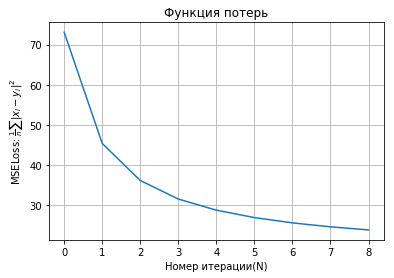

In [150]:
plt.figure()
plt.title(u"Функция потерь")
plt.xlabel(u"Номер итерации(N)")
plt.ylabel(u"MSELoss: $\\frac{1}{n} \sum |x_i-y_i|^2$")
plt.grid()
plt.plot(error_train)

In [151]:
test = faces(csv_file=test_landmarks_path,
            root_dir=test_path, transform=transforms.Compose([ToTensor()])
            )

In [152]:
def predict(model, x_val):
    x_val = torch.stack((x_val,)*3).float()
    x_val = x_val.view(1, 3, 96, 96)
    x_val = x_val.resize_(1, 3, 56, 56)
    m = torch.nn.UpsamplingNearest2d(size = (224,224))
    x_val = Variable(x_val, requires_grad=False)
    x_val = m(x_val)
    x_val = model_vgg.features(x_val)
    x_val = x_val.view(x_val.size(0), -1)
    output = lin_model.forward(x_val)
    return output.data.numpy()

In [153]:
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv(test_landmarks_path)

n = 60
#img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)


def plt_test(i):   
    landmarks = landmarks_frame.ix[i, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)
    plt.figure()
    a = test[i]['image'].float()
    #a = a.view(-1)
    f = predict(model, a)
    f = f[0]
    f_1 = f[::2]
    f_2 = f[1::2]
    img_name = landmarks_frame.ix[i, 0]
    plt.figure()
    plt.imshow(io.imread(os.path.join(test_path, img_name)), cmap='gray')
    plt.scatter(f_1, f_2, s=10, marker='.', c='b')
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

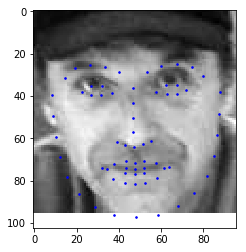

In [154]:
plt_test(5)

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

- Было бы интересно на семинаре узнать некоторые подробности о том, как можно удалять не только последние слои, но и замораживать некоторые свёрточные. А также зачем и когда это могло было бы пригодится.
- Также не очень понятно какой размер тензора подавать на вход претрейн-модели. С этим провозился достаточно долго.
- Если есть возможность, то лучше поподробней останавливайтесь на размерах тензора входа/выхода слоёв модели, с этим висишь большинство времени, а не над самой задачей  